### Пример примитивной кластеризации сообщений из флудилки ###


Для эмбеддинга будем использовать модель Instructor-large, метод кластеризации Kmeans, для визуализации сожмем точки в двухмерную плоскость с помощью t-SNE

In [ ]:
import json
import pandas as pd
import numpy as np

In [ ]:
with open('result.json') as jsmas:
  jsmassages = jsmas.read()

jsmassages = json.loads(jsmassages)

In [ ]:
jsmassages['messages'][1]['text_entities'][0]['text']
msgs = []

for i in jsmassages['messages']:
  if len(i['text_entities']) > 0:
    msgs.append(i['text_entities'][0]['text'])
print(len(msgs), msgs)

def filter(msg: str):
  if msg.isalnum() or msg == '@' or len(msg)>50 or len(msg)<5:
    return 0
  return 1

filtered_msgs = [[i, filter(i)] for i in msgs]
data = pd.DataFrame(filtered_msgs, columns = ['text', 'filter'])
data = data.loc[data['filter'] == 1]
data = data.drop('filter', axis=1)
data.head()

5514 ['ДРУЗЬЯ', 'ВЫ ЗНАЕТЕ ЧТО СЕГОДНЯ', 'ВСЕМИРНЫЙ ДЕНЬ ХИДЖАБА', 'А ЕЩЁ', 'ДЕРЬ РОЖДЕНИЯ ГАЯЗОВА 01 И ГАЯЗОВА 02', 'КАК 01.02', 'ПОЗДРАВЛЯЕМ ', '@povykk', 'с днём десерта кей(к)-поп вас!!🤩🥳', 'Гриш', '@povykk', 'Ты на два часа опоздал', 'с днём международного дня боди арта!! нарисуйте там что-то классное на ваших bodies 🎉', '@Shtrudel7', 'я не буду подстраиваться под каждый часовой пояс', 'я уже им это лично говорил', '@povykk', 'день памяти жертв😇\nдень жертв 💀', 'ураа❗️❗️‼️‼️поздравляю всех!!🥰\nу меня кота макар зовут', 'ты как Ольга корабль', 'сочту за комплимент', 'это комплимент', 'это как "ты богоподобна"', '@povykk', 'Ну и конечно', 'С рождеством !', 'С рождеством 🎄!', 'С днем танца хула!!💃🎊🎉', 'с днём отважных старух!!', 'с днём "измените свой пароль"!', '@Shtrudel7', 'с днём отмены рабства на маврикии и с днём свободы в сша!!! пусть вас всегда сопровождает ветер свободы) 🥳🥳🥳🥳', 'с днём рождения несквик дуо!!', 'Сиамские близнецы?', 'нет, коммунарские двойняшки', 'Это ты верн

,text
1,ВЫ ЗНАЕТЕ ЧТО СЕГОДНЯ
2,ВСЕМИРНЫЙ ДЕНЬ ХИДЖАБА
3,А ЕЩЁ
4,ДЕРЬ РОЖДЕНИЯ ГАЯЗОВА 01 И ГАЯЗОВА 02
5,КАК 01.02


Воспользуемся моделью Instructor-large

In [ ]:
! pip install InstructorEmbedding
! pip install sentence-transformers==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=cea926f65e628734c387e57917bf162b86dab27c15c3feec8f4364881fa4dc86
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from InstructorEmbedding import INSTRUCTOR
import sklearn.cluster

/usr/local/lib/python3.10/dist-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [ ]:

instructions = 'Represent the chat message for the communication of the student for clustering'
N_clasters = 10

model = INSTRUCTOR('hkunlp/instructor-large')

sentences = [[instructions, i] for i in data['text'].tolist()]
sentences = sentences[:10000]

embeddings = model.encode(sentences)

clustering_model = sklearn.cluster.MiniBatchKMeans(n_clusters=N_clasters)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

print(cluster_assignment)


load INSTRUCTOR_Transformer
max_seq_length  512


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 0 7 2]


In [ ]:
data2 = data.copy().tail(1000)

In [ ]:
data['cluster'] = cluster_assignment
#data_1 = data[data['cluster'] == 1]
data

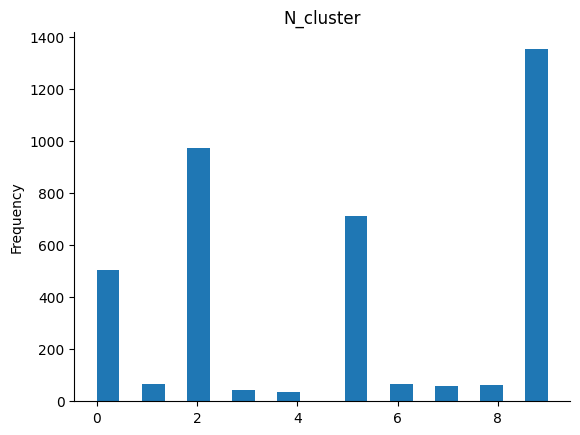

In [ ]:
from matplotlib import pyplot as plt
data['N_cluster'].plot(kind='hist', bins=20, title='N_cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

Видно что алгоритм смог выделить 4 крупных кластера

До OpenAI все же долетели деньги, так что теперь можно воспользоваться их крутыми моделями для эмбеддинга

In [ ]:
! pip install openai
! pip install tiktoken

In [ ]:
! pip install utils
! pip install Transformers

In [ ]:
import tiktoken
from openai import OpenAI
from google.colab import userdata
import plotly
#from utils.embeddings_utils import get_embedding


In [ ]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000

In [ ]:
encoding = tiktoken.get_encoding(embedding_encoding)
data2["n_tokens"] = data2['text'].apply(lambda x: len(encoding.encode(x)))
data2 = data2[data2.n_tokens <= max_tokens]
len(data2)

1000

In [ ]:
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

In [ ]:
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

data2['embedding'] = data2['text'].apply(lambda x: get_embedding(x, model='text-embedding-3-small'))

In [ ]:
data2.head()

,text,n_tokens,embedding
4090,Первый уснул на тусе и побрили налысо,22,"[-0.010350245982408524, 0.018747003749012947, ..."
4093,Такой мииилиииий,9,"[0.02563471347093582, -0.03630999103188515, -0..."
4094,"Да, было",5,"[-0.044242970645427704, 0.023920327425003052, ..."
4095,"Тимур, по-моему",10,"[0.010752340778708458, 0.018034379929304123, -..."
4097,@useinac,4,"[-0.02487299218773842, -0.023953106254339218, ..."


In [ ]:
from sklearn.manifold import TSNE
import matplotlib
from ast import literal_eval
import matplotlib.pyplot as plt
from random import randint

In [ ]:
matrix = np.array(data2.embedding.to_list())
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

<ipython-input-18-6716c90be163>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap=colormap, alpha=0.3)


Text(0.5, 1.0, 'Распределение сообщений по смыслу на плоскости')

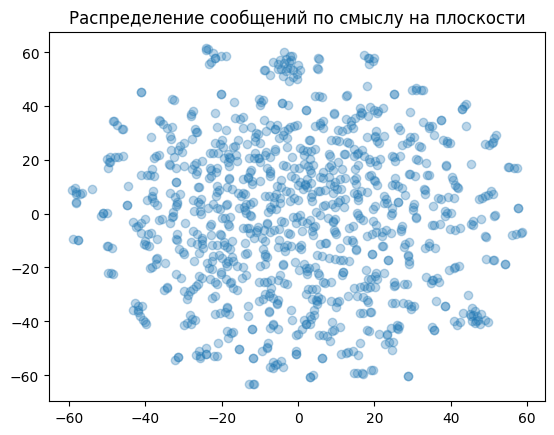

In [ ]:
colors = ["red", "orange", "yellow", "turquiose", "green"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
id_points = data2.text

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, cmap=colormap, alpha=0.3)


plt.title("Распределение сообщений по смыслу на плоскости")

Пока что нет никаких признаков по которым мы может окрасить точки, так что илюстрация по сути не имеет смысла.
Попробуем разбить сообщения на кластеры и покрасить точки в соответствующие своему кластеру цвета, воспользуемся алгоритмом Kmeans

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, n_init=15, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
data2["cluster"] = labels

In [ ]:
data2.head()

,text,n_tokens,embedding,cluster
4090,Первый уснул на тусе и побрили налысо,22,"[-0.010350245982408524, 0.018747003749012947, ...",1
4093,Такой мииилиииий,9,"[0.02563471347093582, -0.03630999103188515, -0...",8
4094,"Да, было",5,"[-0.044242970645427704, 0.023920327425003052, ...",5
4095,"Тимур, по-моему",10,"[0.010752340778708458, 0.018034379929304123, -...",6
4097,@useinac,4,"[-0.02487299218773842, -0.023953106254339218, ...",6


Text(0.5, 1.0, 'Визуализация кластеризации текстовых сообщений на плоскости с использованием t-SNE')

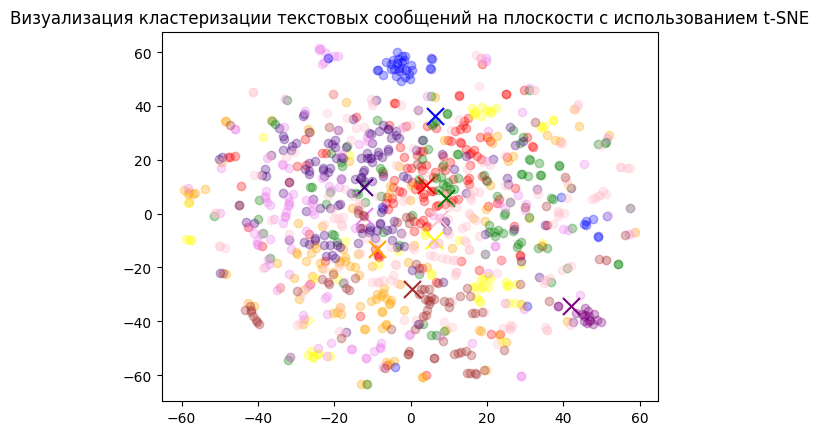

In [ ]:
x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]

for category, color in enumerate(['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'brown']):
    xs = np.array(x)[data2.cluster == category]
    ys = np.array(y)[data2.cluster == category]
    plt.scatter(xs, ys, c=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=150)
plt.title("Визуализация кластеризации текстовых сообщений на плоскости с использованием t-SNE")

In [ ]:
data2

,text,n_tokens,embedding,cluster
4090,Первый уснул на тусе и побрили налысо,22,"[-0.010350245982408524, 0.018747003749012947, ...",1
4093,Такой мииилиииий,9,"[0.02563471347093582, -0.03630999103188515, -0...",8
4094,"Да, было",5,"[-0.044242970645427704, 0.023920327425003052, ...",5
4095,"Тимур, по-моему",10,"[0.010752340778708458, 0.018034379929304123, -...",6
4097,@useinac,4,"[-0.02487299218773842, -0.023953106254339218, ...",6
...,...,...,...,...
5507,у меня самое казырное место,13,"[-0.00964339729398489, 0.01973119005560875, -0...",1
5508,Хуевое видео какое то,11,"[-0.046925850212574005, 0.017946109175682068, ...",8
5511,Ксюша Ярох🤩,13,"[-0.01172932330518961, -0.012826149351894855, ...",1
5512,"Сенечка, люблю тебя, солнце",16,"[0.020823337137699127, -0.023298243060708046, ...",1


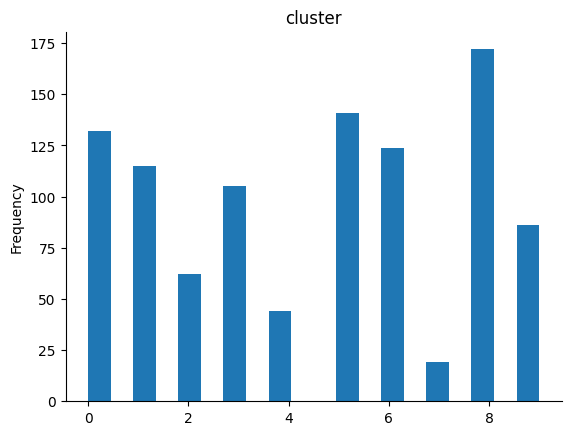

In [ ]:
data2['cluster'].plot(kind='hist', bins=20, title='cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data2[data2['cluster'] == 7]

,text,n_tokens,embedding,cluster
4127,поздравляю!!!!,6,"[0.025592627003788948, -0.06074047461152077, -...",7
5445,С днем Рождения котик🥳,14,"[0.024318043142557144, -0.02506018429994583, -...",7
5446,С днём ораторского мастерства и дебатов!!!!’,21,"[0.0006577689782716334, 0.025248389691114426, ...",7
5450,А ещё день пива кстати,13,"[-0.02798960730433464, 0.0020476088393479586, ...",7
5452,Ну точно твой день,9,"[-0.009483019821345806, 0.008860491216182709, ...",7
5456,с днём пива,9,"[-0.01537656132131815, 0.0029455102048814297, ...",7
5457,с днём рождения!!🎊🥳,16,"[0.052475687116384506, -0.012900792062282562, ...",7
5458,с днём джигита!! 🥳🥳🥳,20,"[0.015440480783581734, -0.012780239805579185, ...",7
5460,с днём рождения!!,10,"[0.05262194573879242, -0.002839618595317006, 0...",7
5462,с праздником!!🤲,10,"[0.03108307532966137, 0.015226430259644985, -0...",7


В седьмом кластере мы видим милые поздравление с днем рождения

In [ ]:
sorted_onClasters_data2 = data2.sort_values(by='cluster')
sorted_onClasters_data2.drop('embedding', axis=1).to_csv('sorted_data2.csv', index=False)